In [1]:
import matplotlib.pyplot as plt
from ekpy import control
from ekpy.control.instruments import keysight81150a, keysightdsox3024a
from singlePVhysteresis import FEHysteresis
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate

2


This is will be deleted after I can get the scope to digitize one set of info and trig successfuly from the software trigger from
the wavegen

In [2]:
rm = control.ResourceManager()
rm.list_resources()

('USB0::0x0957::0x17A6::MY63080078::INSTR', 'GPIB0::8::INSTR')

In [3]:
scope = rm.open_resource('USB0::0x0957::0x17A6::MY63080078::INSTR')
wavegen = rm.open_resource('GPIB0::8::INSTR')

In [4]:
def pv_hysteresis_wf(initial_delay, freq, pulse_delay, voltage, qtimepoints=12):
	'''
	Modified from my original one to only return my time_arr thats been interpolated using good commands
	ayo this already interps the voltage array??? 
	'''
	#first build Qtime
	initial_delay = float(initial_delay)
	freq = float(freq)
	pulse_delay = float(pulse_delay)
	voltage = float(voltage)
	q_time = []
	t_increment = 0.0005/freq
	sumsofar = initial_delay
	q_time.append(sumsofar)
	count = 0
	for i in range(qtimepoints - 1):
		if count == 2:
			count = 0
			value = sumsofar + pulse_delay
		else:
			value = sumsofar + t_increment
			count += 1
		q_time.append(value)
		sumsofar = value
	#Now we build the time_array
	time_array = []
	time_array.append(0)
	time_array.append(initial_delay)
	t_increment2 = 0.00025/freq
	for i in range(4):
		sumsofar2 = 0
		last_element = time_array[-1]
		sumsofar2 = t_increment2 + last_element
		time_array.append(sumsofar2)
		sumsofar2 += t_increment
		time_array.append(sumsofar2)
		sumsofar2 += t_increment2
		time_array.append(sumsofar2)
		sumsofar2 += pulse_delay
		time_array.append(sumsofar2)
	
	#Now we calculate the Waveform frequency
	waveform_freq = 1/time_array[-1]
	#Now we calculate the interpolated time [This is a dumb method probably way easier way to do it]
	interp_time = []
	interp_time.append(0)
	iteration_count = 10000 - 1
	for i in range(iteration_count):
		interp_time.append((i + 1) * (time_array[-1]/iteration_count))
	#note this was the same shit as doing like np.linearinterpolate or linspace with max being the last element

	#Now we make a voltage array
	voltage_array = voltage*np.array([0,0,1,-1,0,0,1,-1,0,0,-1,1,0,0,-1,1,0,0])
	temp = interpolate.interp1d(time_array, voltage_array)
	interp_voltage_array = temp(interp_time)
	#only thing we use from this is interp_voltage_array wtf
	return q_time, time_array, waveform_freq, interp_time, interp_voltage_array

In [5]:
keysightdsox3024a.idn(scope)

'AGILENT TECHNOLOGIES,DSO-X 3024A,MY63080078,02.65.2021030741\n'

In [6]:
keysight81150a.idn(wavegen)

'Agilent Technologies,81150A,MY53821602,3.0.0.0-4.6\n'

okay so first we will setup the wavegen and scope (start with a simple sine wave)

In [7]:
keysightdsox3024a.initialize(scope)
keysightdsox3024a.configure_timebase(scope, scale='200e-6') #This is a random number I picked
keysightdsox3024a.configure_channel(scope, channel='1', vertical_scale='0.25', impedance='ONEM')
keysightdsox3024a.configure_channel(scope, channel='2', vertical_scale='0.008', impedance='FIFT')
#keysightdsox3024a.configure_scale(scope, channel='1', vertical_scale='4') #All this does is set the timebase again aka scale, and then the vertical range
#NOTE HERE FOR ME TO TEST, THE CONFIGURE SCALE COMMAND IS USELESS IMO SINCE IT IS DONE BEFORE IN CONFIGURE CHANNEL AND NOTHING IS DIFFERENT, HOWEVER IT ADDS A 'V' IN THE COMMAND STRUCTURE
keysightdsox3024a.configure_trigger_characteristics(scope, trigger_source='EXT', low_voltage_level='0.75', high_voltage_level='0.95', sweep='NORM')
keysightdsox3024a.configure_trigger_edge(scope, trigger_source='EXT', input_coupling='DC')

In [9]:
keysight81150a.initialize(wavegen)
keysight81150a.configure_impedance(wavegen, '1', source_impedance='50.0', load_impedance='1000000')
keysight81150a.configure_trigger(wavegen, '1', source='MAN')
keysight81150a.configure_output_amplifier(wavegen, '1') #note this is the channel on the wavegen
#note we are just taking the waveform stored on the wavegen, sike now we are making it as well
q_time_arr, time_array, waveform_freq, interp_time_arr, interp_voltage_array = pv_hysteresis_wf('5E-5', '10', '5E-6', '1')
keysight81150a.create_arb_wf(wavegen, interp_voltage_array)
keysight81150a.configure_arb_wf(wavegen, '1', 'VOLATILE', gain='1', freq='1000')
#keysight81150a.set_output_wf(wavegen)


NOW we try to take the data, aka initiate and do all that fun stuff

In [10]:
keysightdsox3024a.initiate(scope)

In [11]:
keysight81150a.enable_output(wavegen)
#time.sleep(0.5)
keysight81150a.send_software_trigger(wavegen)


In [12]:
scope.query("*OPC?")

'1\n'

In [13]:
keysightdsox3024a.setup_wf(scope, 'CHAN1')
meta_data_v, time_v, wfm_v = keysightdsox3024a.query_wf(scope)

In [14]:
keysightdsox3024a.setup_wf(scope, 'CHAN2')
meta_data_c, time_c, wfm_c = keysightdsox3024a.query_wf(scope)

In [15]:
scope.query("*OPC?")

'1\n'

In [16]:
start = time.time()
now = 0
while now < start + 2:
    #do nothing
    now = time.time()
print("2 seconds have passed")

2 seconds have passed


In [17]:
start = time.time()
now = 0
while now < start + 2:
    
    now = time.time()
print("2 seconds have passed")

2 seconds have passed


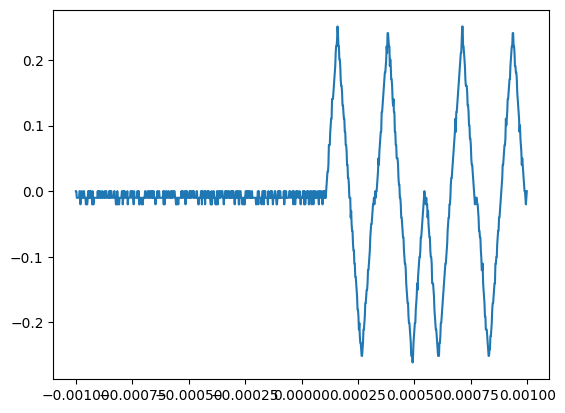

In [18]:
plt.plot(time_v, wfm_v)
plt.show()

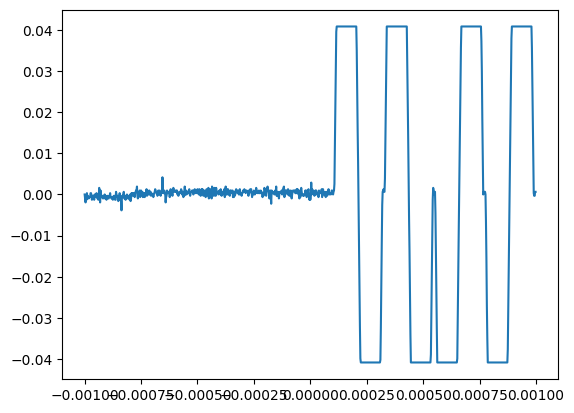

In [19]:
plt.plot(time_c, wfm_c)
plt.show()

NOW WE WILL PUT ALL THE CODE IN ONE BLOCK AND RUN IT AND SEE IF IT ERRORS

2


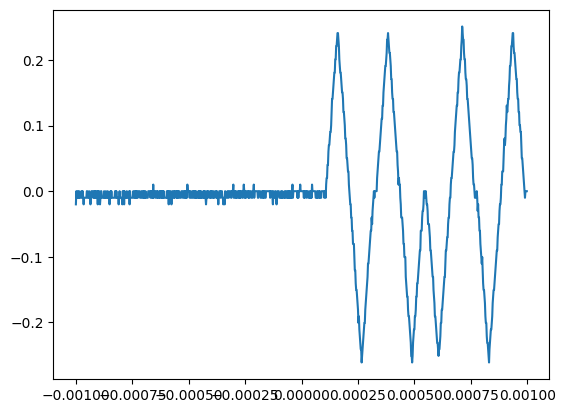

In [1]:
import matplotlib.pyplot as plt
from ekpy import control
from ekpy.control.instruments import keysight81150a, keysightdsox3024a
from singlePVhysteresis import FEHysteresis
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate

def pv_hysteresis_wf(initial_delay, freq, pulse_delay, voltage, qtimepoints=12):
	'''
	Modified from my original one to only return my time_arr thats been interpolated using good commands
	ayo this already interps the voltage array??? 
	'''
	#first build Qtime
	initial_delay = float(initial_delay)
	freq = float(freq)
	pulse_delay = float(pulse_delay)
	voltage = float(voltage)
	q_time = []
	t_increment = 0.0005/freq
	sumsofar = initial_delay
	q_time.append(sumsofar)
	count = 0
	for i in range(qtimepoints - 1):
		if count == 2:
			count = 0
			value = sumsofar + pulse_delay
		else:
			value = sumsofar + t_increment
			count += 1
		q_time.append(value)
		sumsofar = value
	#Now we build the time_array
	time_array = []
	time_array.append(0)
	time_array.append(initial_delay)
	t_increment2 = 0.00025/freq
	for i in range(4):
		sumsofar2 = 0
		last_element = time_array[-1]
		sumsofar2 = t_increment2 + last_element
		time_array.append(sumsofar2)
		sumsofar2 += t_increment
		time_array.append(sumsofar2)
		sumsofar2 += t_increment2
		time_array.append(sumsofar2)
		sumsofar2 += pulse_delay
		time_array.append(sumsofar2)
	
	#Now we calculate the Waveform frequency
	waveform_freq = 1/time_array[-1]
	#Now we calculate the interpolated time [This is a dumb method probably way easier way to do it]
	interp_time = []
	interp_time.append(0)
	iteration_count = 10000 - 1
	for i in range(iteration_count):
		interp_time.append((i + 1) * (time_array[-1]/iteration_count))
	#note this was the same shit as doing like np.linearinterpolate or linspace with max being the last element

	#Now we make a voltage array
	voltage_array = voltage*np.array([0,0,1,-1,0,0,1,-1,0,0,-1,1,0,0,-1,1,0,0])
	temp = interpolate.interp1d(time_array, voltage_array)
	interp_voltage_array = temp(interp_time)
	#only thing we use from this is interp_voltage_array wtf
	return q_time, time_array, waveform_freq, interp_time, interp_voltage_array

rm = control.ResourceManager()
rm.list_resources()

scope = rm.open_resource('USB0::0x0957::0x17A6::MY63080078::INSTR')
wavegen = rm.open_resource('GPIB0::8::INSTR')

keysightdsox3024a.idn(scope)
keysight81150a.idn(wavegen)

keysightdsox3024a.initialize(scope)
keysightdsox3024a.configure_timebase(scope, scale='200e-6') #This is a random number I picked
keysightdsox3024a.configure_channel(scope, channel='1', vertical_scale='0.25', impedance='ONEM')
keysightdsox3024a.configure_channel(scope, channel='2', vertical_scale='0.008', impedance='FIFT')
#keysightdsox3024a.configure_scale(scope, channel='1', vertical_scale='4') #All this does is set the timebase again aka scale, and then the vertical range
#NOTE HERE FOR ME TO TEST, THE CONFIGURE SCALE COMMAND IS USELESS IMO SINCE IT IS DONE BEFORE IN CONFIGURE CHANNEL AND NOTHING IS DIFFERENT, HOWEVER IT ADDS A 'V' IN THE COMMAND STRUCTURE
keysightdsox3024a.configure_trigger_characteristics(scope, trigger_source='EXT', low_voltage_level='0.75', high_voltage_level='0.95', sweep='NORM')
keysightdsox3024a.configure_trigger_edge(scope, trigger_source='EXT', input_coupling='DC')

keysight81150a.initialize(wavegen)
keysight81150a.configure_impedance(wavegen, '1', source_impedance='50.0', load_impedance='1000000')
keysight81150a.configure_trigger(wavegen, '1', source='MAN')
keysight81150a.configure_output_amplifier(wavegen, '1') #note this is the channel on the wavegen
#note we are just taking the waveform stored on the wavegen, sike now we are making it as well
q_time_arr, time_array, waveform_freq, interp_time_arr, interp_voltage_array = pv_hysteresis_wf('5E-5', '10', '5E-6', '1')
keysight81150a.create_arb_wf(wavegen, interp_voltage_array)
keysight81150a.configure_arb_wf(wavegen, '1', 'VOLATILE', gain='1', freq='1000')
#keysight81150a.set_output_wf(wavegen)

keysightdsox3024a.initiate(scope)

keysight81150a.enable_output(wavegen)
#time.sleep(0.5)
keysight81150a.send_software_trigger(wavegen)

scope.query("*OPC?")

keysightdsox3024a.setup_wf(scope, 'CHAN1')
meta_data_v, time_v, wfm_v = keysightdsox3024a.query_wf(scope)

keysightdsox3024a.setup_wf(scope, 'CHAN2')
meta_data_c, time_c, wfm_c = keysightdsox3024a.query_wf(scope)

plt.plot(time_v, wfm_v)

plt.show()